# Missing data imputation using optimal transport

In this notebook, we will show how to use optimal transport to impute missing values in an incomplete dataset.

The methods we will use are described in the following paper:

B. Muzellec, J. Josse, C. Boyer, M. Cuturi, [Missing Data Imputation using Optimal Transport](https://arxiv.org/pdf/2002.03860.pdf).

## Imports and installs

In [1]:
# Ignore this cell if the corresponding packages are already installed

!pip install pot
!pip install geomloss

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import os

from geomloss import SamplesLoss

from imputers import OTimputer, RRimputer

from utils import *
from data_loaders import dataset_loader
from softimpute import softimpute, cv_softimpute

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

## Data loading

The dataset loader utilities assume there is a "datasets/" folder in the current directory.

In [3]:
if not os.path.isdir("datasets"):
    os.mkdir("datasets")

Load the data and whiten it.
In a real missing data situation, the mean and std would have to be estimated on non-missing data.

In [4]:
ground_truth = scale(dataset_loader("wine")) # "wine" can be replaced with any of the datasets
                                             # supported by dataset_loader (see data_loaders.py)

X_true = torch.from_numpy(ground_truth)

## Missing data generation

Let's now simulate missing data. We will assume that the data is missing completely at random (MCAR) with a 50% probability.
Additional MAR and MNAR missing data mechanisms are available in utils.py.

In [5]:
np.random.seed(42)

p = 0.5

mask = np.random.rand(*ground_truth.shape) < p #True for missing values, false for others
x_miss = np.copy(ground_truth)

x_miss[mask] = np.nan
X_miss = torch.from_numpy(x_miss)

## Hyperparameters

In [6]:
n, d = X_miss.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon = pick_epsilon(X_miss) # Set the regularization parameter as a multiple of the median distance, as per the paper.

## Sinkhorn imputation (Algorithm 1)

In [7]:
sk_imputer = OTimputer(eps=epsilon, batchsize=batchsize, lr=lr, niter=2000)

In [8]:
sk_imp, sk_maes, sk_rmses = sk_imputer.fit_transform(X_miss, verbose=True, report_interval=500, X_true=X_true)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.2697
INFO:root:Iteration 0:	 Loss: 1.5279	 Validation MAE: 0.8615	RMSE: 1.0539
INFO:root:Iteration 500:	 Loss: 1.0651	 Validation MAE: 0.6361	RMSE: 0.8679
INFO:root:Iteration 1000:	 Loss: 0.9501	 Validation MAE: 0.6311	RMSE: 0.8674
INFO:root:Iteration 1500:	 Loss: 1.0874	 Validation MAE: 0.6343	RMSE: 0.8725


## Round-robin imputation (Algorithm 3)

Round-robin imputation models iteratively impute each variable using all the other variables.
The imputation is performed according to an optimal transport criterion, as in Algorithm 3 in the paper.
Any model can be used to perform the variable imputation. It is even possible to specify one type of model per variable
(e.g. predict a variable with a linear model, and an other with an MLP), as long as those models gave trainable parameters.

We give here two examples. In the first, variables are predicted using linear models, and in the second using a MLP.

Note that even if each variable has an associated model of the same type as the others,
those models have distinct sets of parameters.

### Linear round-robin

In [9]:
#Create the imputation models
d_ = d - 1
models = {}

for i in range(d):
    models[i] = nn.Linear(d_, 1)

#Create the imputer
lin_rr_imputer = RRimputer(models, eps=epsilon, lr=lr)

In [10]:
lin_imp, lin_maes, lin_rmses = lin_rr_imputer.fit_transform(X_miss, verbose=True, X_true=X_true)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.7705	Validation MAE: 0.7467	RMSE:  0.9541
INFO:root:Iteration 1:	 Loss: 1.3344	Validation MAE: 0.7117	RMSE:  0.9366
INFO:root:Iteration 2:	 Loss: 1.3620	Validation MAE: 0.6858	RMSE:  0.9108
INFO:root:Iteration 3:	 Loss: 1.3318	Validation MAE: 0.6802	RMSE:  0.8995
INFO:root:Iteration 4:	 Loss: 1.3122	Validation MAE: 0.6704	RMSE:  0.8923
INFO:root:Iteration 5:	 Loss: 1.2849	Validation MAE: 0.6709	RMSE:  0.8933
INFO:root:Iteration 6:	 Loss: 1.2932	Validation MAE: 0.6682	RMSE:  0.8883
INFO:root:Iteration 7:	 Loss: 1.2972	Validation MAE: 0.6696	RMSE:  0.8919
INFO:root:Iteration 8:	 Loss: 1.3920	Validation MAE: 0.6676	RMSE:  0.8886
INFO:root:Iteration 9:	 Loss: 1.2369	Validation MAE: 0.6703	RMSE:  0.8927
INFO:root:Early stopping criterion not reached


### MLP round-robin

In [11]:
#Create the imputation models
d_ = d - 1
models = {}

for i in range(d):
    models[i] = nn.Sequential(nn.Linear(d_, 2 * d_),
                              nn.ReLU(),
                              nn.Linear(2 * d_, d_),
                              nn.ReLU(),
                              nn.Linear(d_, 1))

#Create the imputer
mlp_rr_imputer = RRimputer(models, eps=epsilon, lr=lr)

In [12]:
mlp_imp, mlp_maes, mlp_rmses = mlp_rr_imputer.fit_transform(X_miss, verbose=True, X_true=X_true)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.2783	Validation MAE: 0.6612	RMSE:  0.8848
INFO:root:Iteration 1:	 Loss: 1.2325	Validation MAE: 0.6445	RMSE:  0.8709
INFO:root:Iteration 2:	 Loss: 1.3013	Validation MAE: 0.6438	RMSE:  0.8773
INFO:root:Iteration 3:	 Loss: 1.2987	Validation MAE: 0.6464	RMSE:  0.8824
INFO:root:Iteration 4:	 Loss: 1.6957	Validation MAE: 0.6438	RMSE:  0.8851
INFO:root:Iteration 5:	 Loss: 1.2492	Validation MAE: 0.6536	RMSE:  0.8967
INFO:root:Iteration 6:	 Loss: 1.2932	Validation MAE: 0.6582	RMSE:  0.8995
INFO:root:Iteration 7:	 Loss: 1.2198	Validation MAE: 0.6636	RMSE:  0.9100
INFO:root:Iteration 8:	 Loss: 1.2143	Validation MAE: 0.6684	RMSE:  0.9153
INFO:root:Iteration 9:	 Loss: 1.3173	Validation MAE: 0.6648	RMSE:  0.9102
INFO:root:Early stopping criterion not reached


## Baselines

Let's compare OT imputations to some baselines. As in the paper, we consider the following baselines: (i) mean imputation, (ii) iterated conditional ridge regression and (iii) softimpute.

In [13]:
# Imputation by the means
mean_imp = SimpleImputer().fit_transform(x_miss)
mean_mae = MAE(mean_imp, ground_truth, mask)
mean_rmse = RMSE(mean_imp, ground_truth, mask)

# ICE
ice_imp = IterativeImputer(random_state=0, max_iter=50).fit_transform(x_miss)
ice_mae = MAE(ice_imp, ground_truth, mask)
ice_rmse = RMSE(ice_imp, ground_truth, mask)

# Softimpute
cv_error, grid_lambda = cv_softimpute(x_miss, grid_len=15)
lbda = grid_lambda[np.argmin(cv_error)]
soft_imp = softimpute((x_miss), lbda)[1]

soft_mae = MAE(soft_imp, ground_truth, mask)
soft_rmse = RMSE(soft_imp, ground_truth, mask)

## Comparison plots

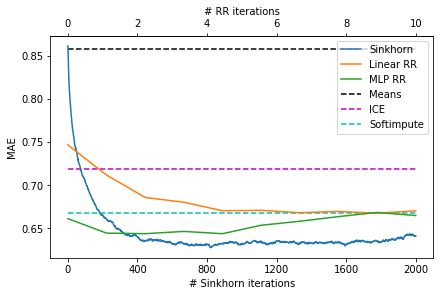

In [16]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

secax = ax.secondary_xaxis('top', functions=(lambda x: x * len(lin_maes) / npoints, lambda x: x * npoints / len(lin_maes)))
secax.set_xlabel('# RR iterations')

ax.plot(np.linspace(0, 1, len(lin_maes)) * npoints, lin_maes, label='Linear RR')
ax.plot(np.linspace(0, 1, len(mlp_maes)) * npoints, mlp_maes, label='MLP RR')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

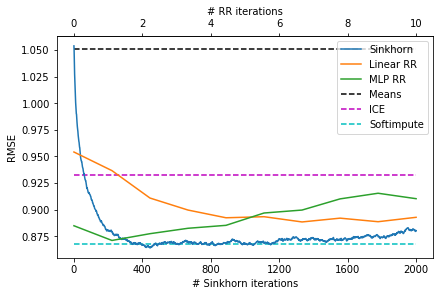

In [17]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

secax = ax.secondary_xaxis('top', functions=(lambda x: x * len(lin_maes) / npoints, lambda x: x * npoints/ len(lin_maes)))
secax.set_xlabel('# RR iterations')

ax.plot(np.linspace(0, 1, len(lin_rmses)) * npoints, lin_rmses, label='Linear RR')
ax.plot(np.linspace(0, 1, len(mlp_maes)) * npoints, mlp_rmses, label='MLP RR')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()



